In [13]:
#-------------------------------------------------------------------------------
#----- Libraries ---------------------------------------------------------------
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator, NullLocator
from matplotlib.lines import Line2D

#-------------------------------------------------------------------------------
#----- Read input ADDA files ---------------------------------------------------
def load_adda_data(base_path, filename_matrix="mueller", filename_eff="CrossSec"):
    base = Path(base_path)
    data = {}

    if not base.is_dir():
        print(f"[WARN] base_path no es un directorio: {base}")
        return data

    for por_dir in sorted(p for p in base.glob("P_*") if p.is_dir()):
        porosity = por_dir.name
    
        for comp_dir in sorted(p for p in por_dir.glob("comp*") if p.is_dir()):
            comp = comp_dir.name
            
            for wl_dir in sorted(p for p in comp_dir.glob("*_w*") if p.is_dir()):
                m = re.search(r"w(\d+)", wl_dir.name)
                if not m:
                    continue
                lambda_um = int(m.group(1))

                for size_dir in sorted(p for p in wl_dir.glob("aV_*") if p.is_dir()):
                    m_av = re.search(r"aV_(\d+)$", size_dir.name)
                    if not m_av:
                        continue
                    aV_int = int(m_av.group(1))
                    a_V_um = aV_int / 10000.0

                    mat_path = size_dir / filename_matrix
                    eff_path = size_dir / filename_eff
                    if (not mat_path.is_file()) or (not eff_path.is_file()):
                        continue

                    try:
                        mat = np.genfromtxt(mat_path, dtype=float)
                        if mat.ndim == 1:
                            mat = mat[np.newaxis, :]
                        if mat.shape[0] > 0 and not np.isfinite(mat[0, 0]):
                            mat = mat[1:]
                        else:
                            mat = mat[1:]

                        angles = mat[:, 0]
                        values = mat[:, 1:]

                        S = np.zeros((len(angles), 6), dtype=float)
                        S[:, 0] = values[:, 0]   # S11
                        S[:, 1] = values[:, 1]   # S12
                        S[:, 2] = values[:, 5]   # S22
                        S[:, 3] = values[:, 10]  # S33
                        S[:, 4] = values[:, 11]  # S34
                        S[:, 5] = values[:, 15]  # S44

                        # --- secciones eficaces ---
                        C = np.genfromtxt(eff_path, dtype=float)

                        C_ext = float(C[0, 2])
                        C_abs = float(C[2, 2])
                        C_sca = abs(C_ext - C_abs)

                        Q_ext = float(C[1, 2])
                        Q_abs = float(C[3, 2])
                        Q_sca = abs(Q_ext - Q_abs)
                        
                        key = ("Porous_Sphere", porosity, comp, lambda_um, a_V_um)
                        data[key] = {
                            "angles": angles,
                            "S_matrix": S,
                            "Q_ext": Q_ext,
                            "Q_abs": Q_abs,
                            "Q_sca": Q_sca,
                            "C_ext": C_ext,
                            "C_abs": C_abs,
                            "C_sca": C_sca,
                            "a_V_um": a_V_um,
                            "lambda_um": lambda_um,
                            "composition": comp,
                            "porosity": porosity,
                            "method": "ADDA",
                        }

                    except Exception as e:
                        print(f"[ERROR] leyendo {size_dir}: {e}")

    return data


#-------------------------------------------------------------------------------
#----- Read input MSTM files ---------------------------------------------------
def load_mstm_data(base_path="raw/MSTM/Fractal_Aggregates", filename_pattern="mstm_aV_*.dat", transform_to_adda=True):
    base = Path(base_path)
    data = {}

    if not base.is_dir():
        print(f"[WARN] base_path is not a directory: {base}")
        return data

    for df_dir in sorted(p for p in base.glob("Df_*") if p.is_dir()):
        df = df_dir.name
        for comp_dir in sorted(p for p in df_dir.glob("comp*") if p.is_dir()):
            comp = comp_dir.name
            for wl_dir in sorted(p for p in comp_dir.glob("*_w*") if p.is_dir()):
                m = re.search(r"w(\d+)", wl_dir.name)
                if not m:
                    continue
                lambda_um = int(m.group(1))

                for fpath in sorted(wl_dir.glob(filename_pattern)):
                    m_av = re.search(r"mstm_aV_(\d+)\.dat$", fpath.name)
                    if not m_av:
                        continue
                    aV_int = int(m_av.group(1))
                    a_V_um = aV_int / 10000.0

                    try:
                        lines = fpath.read_text(encoding="utf-8").splitlines()

                        if len(lines) < 6:
                            print(f"[WARN] file too short: {fpath}")
                            continue

                        def _find_idx(prefix):
                            pl = prefix.lower()
                            for ii, ln in enumerate(lines):
                                if ln.strip().lower().startswith(pl):
                                    return ii
                            return -1

                        i_len = _find_idx("length scale factor")
                        i_rad = _find_idx("volume cluster radius")
                        i_eff = _find_idx("total extinction, absorption, scattering efficiencies")
                        i_th  = _find_idx("theta")

                        if min(i_len, i_rad, i_eff, i_th) < 0:
                            print(f"[WARN] Headers not found in: {fpath}")
                            continue
                        if i_len+1 >= len(lines) or i_rad+1 >= len(lines) or i_eff+1 >= len(lines) or i_th+1 >= len(lines):
                            print(f"[WARN] Short file in: {fpath}")
                            continue

                        length_scale = float(lines[i_len+1].strip().split()[0])

                        r_vals = list(map(float, lines[i_rad+1].strip().split()))
                        if len(r_vals) < 4:
                            print(f"[WARN] Radios incompletos en {fpath}")
                            continue
                        volume_cluster_radius, area_mean_sphere_radius, circumscribing_radius, cross_section_radius = r_vals[:4]

                        q_vals = list(map(float, lines[i_eff+1].strip().split()))
                        if len(q_vals) < 3:
                            print(f"[WARN] Efficiencies incompletas en {fpath}")
                            continue
                        Q_ext, Q_abs, Q_sca = q_vals[:3]

                        mat = np.genfromtxt(lines[i_th+1:], dtype=float)
                        if mat.ndim == 1:
                            mat = mat[np.newaxis, :]
                        if mat.shape[1] < 7:
                            print(f"[WARN] Table with insufficient columns in: {fpath}")
                            continue

                        angles_all = mat[:, 0]
                        vals_all   = mat[:, 1:7]
                        mask = np.isfinite(angles_all) & np.all(np.isfinite(vals_all), axis=1)
                        mask &= (angles_all >= -1e-8) & (angles_all <= 180.0 + 1e-8)
                        mat = mat[mask]

                        order = np.argsort(mat[:, 0], kind="mergesort")
                        mat = mat[order]
                        uniq_theta, idx = np.unique(mat[:, 0], return_index=True)
                        mat = mat[idx]

                        angles = mat[:, 0]
                        values = mat[:, 1:7]

                        S = np.zeros((len(angles), 6), dtype=float)
                        S[:, 0] = values[:, 0]  # S11
                        S[:, 1] = values[:, 1]  # S12
                        S[:, 2] = values[:, 2]  # S22
                        S[:, 3] = values[:, 3]  # S33
                        S[:, 4] = values[:, 4]  # S34
                        S[:, 5] = values[:, 5]  # S44

                        if transform_to_adda and S.shape[0] > 0:
                            S[:, 1:] *= S[:, [0]]

                        area = np.pi * (cross_section_radius ** 2)
                        factor = (lambda_um / (2.0 * np.pi)) ** 2
                        C_ext = Q_ext * area * factor
                        C_abs = Q_abs * area * factor
                        C_sca = abs(Q_sca * area * factor)

                        key = ("Fractal_Aggregates", df, comp, lambda_um, a_V_um)
                        data[key] = {
                            "angles": angles,
                            "S_matrix": S,
                            "Q_ext": Q_ext,
                            "Q_abs": Q_abs,
                            "Q_sca": Q_sca,
                            "C_ext": C_ext,
                            "C_abs": C_abs,
                            "C_sca": C_sca,
                            "length_scale": length_scale,
                            "volume_cluster_radius": volume_cluster_radius,
                            "area_mean_sphere_radius": area_mean_sphere_radius,
                            "circumscribing_radius": circumscribing_radius,
                            "cross_section_radius": cross_section_radius,
                            "a_V_um": a_V_um,
                            "lambda_um": lambda_um,
                            "composition": comp,
                            "df": df,
                            "method": "MSTM",
                        }

                    except Exception as e:
                        print(f"[ERROR] leyendo {fpath}: {e}")

    return data


#-------------------------------------------------------------------------------
#----- Read input MIE files ----------------------------------------------------
def load_mie_data(base_path, filename_pattern="mie_aV_*.out"):
    base = Path(base_path)
    data = {}

    if not base.is_dir():
        print(f"[WARN] base_path is not a directory: {base}")
        return data

    for comp_dir in sorted(p for p in base.glob("comp*") if p.is_dir()):
        comp = comp_dir.name

        for wl_dir in sorted(p for p in comp_dir.glob("*_w*") if p.is_dir()):
            m = re.search(r"w(\d+)", wl_dir.name)
            if not m:
                continue
                
            lambda_um = int(m.group(1))

            for mie_file in sorted(wl_dir.glob(filename_pattern)):
                m_av = re.search(r"mie_aV_(\d+)\.out$", mie_file.name)
                if not m_av:
                    continue
                aV_int = int(m_av.group(1))
                a_V_um = aV_int / 10000.0

                try:
                    with open(mie_file, "r") as f:
                        lines = f.readlines()

                    C_sca = float(lines[1].split()[0])
                    C_ext = float(lines[2].split()[0])
                    C_abs = C_ext - C_sca

                    Q_sca = C_sca/(np.pi*(a_V_um**2))
                    Q_ext = C_ext/(np.pi*(a_V_um**2))
                    Q_abs = C_abs/(np.pi*(a_V_um**2))
                    
                    mat = np.genfromtxt(lines[5:], dtype=float)
                    if mat.ndim == 1:
                        mat = mat[np.newaxis, :]

                    angles = mat[:, 0]
                    values = mat[:, 1:]

                    S = np.zeros((len(angles), 6), dtype=float)
                    S[:, 0] = values[:, 0]   # S11
                    S[:, 1] = values[:, 1]   # S12
                    S[:, 2] = values[:, 5]   # S22
                    S[:, 3] = values[:, 10]  # S33
                    S[:, 4] = values[:, 11]  # S34
                    S[:, 5] = values[:, 15]  # S44

                    key = ("Solid_Sphere", "compact", comp, lambda_um, a_V_um)

                    data[key] = {
                        "angles": angles,
                        "S_matrix": S,
                        "Q_ext": Q_ext,
                        "Q_abs": Q_abs,
                        "Q_sca": Q_sca,
                        "C_ext": C_ext,
                        "C_abs": C_abs,
                        "C_sca": C_sca,
                        "a_V_um": a_V_um,
                        "lambda_um": lambda_um,
                        "composition": comp,
                        "method": "MIE",
                    }

                except Exception as e:
                    print(f"[ERROR] leyendo {mie_file}: {e}")

    return data


#-------------------------------------------------------------------------------
#----- Normalization function --------------------------------------------------
def normalization_function(S_matrix, angles_deg):
    theta = np.deg2rad(angles_deg)
    dtheta = np.gradient(theta)

    F11 = S_matrix[:,0]
    integrand = F11*np.sin(theta)
    integral = np.sum(integrand*dtheta)

    if integral == 0:
        raise ValueError("Integral of F11 * sin(theta) is zero. Cannot normalize.")

    S_matrix_normalized = S_matrix/integral
    return S_matrix_normalized


#-------------------------------------------------------------------------------
#----- Size Distribution -------------------------------------------------------
def size_distribution(data_dict, alpha, kk_wav, angles, rr):
    keys = sorted(data_dict.keys())
    nn = len(keys)
    ntheta = len(data_dict[keys[0]]['angles'])
    nF = 6

    PP_raw = np.zeros((nn, ntheta, nF))
    sigma_sca = np.zeros(nn)
    sigma_ext = np.zeros(nn)
    sigma_abs = np.zeros(nn)

    for ii, key in enumerate(keys):
        S = data_dict[key]['S_matrix']
        PP_raw[ii,:,:] = S
        sigma_sca[ii] = data_dict[key]['C_sca']
        sigma_ext[ii] = data_dict[key]['C_ext']
        sigma_abs[ii] = data_dict[key]['C_abs']

    # Normalize scattering matrices
    PP_N = np.zeros_like(PP_raw)
    for ii in range(nn):
        PP_N[ii,:,:] = normalization_function(PP_raw[ii,:,:], angles_deg=angles)

    # Size distribution function n(r)
    if alpha == 1.0:
        CC = 1.0/np.log(rr[-1]/rr[0])
    else:
        CC = (1.-alpha)/(rr[-1]**(1.-alpha) - rr[0]**(1.-alpha))
    nr = CC*rr**(-alpha)
    
    total_sum = 0.
    for ii in range(nn-1):
        dr = rr[ii+1] - rr[ii]
        total_sum += 0.5*(nr[ii+1] + nr[ii])*dr
        
    nr *= 1/total_sum                                # n(r) normalization equal to 1

    # Averaged mass in [g]
    bulk_density = 1.675                             # DSHARP Bulk density in g/cm^3
    mass_avg = 0.
    
    # Averaged optical properties
    sigma_sca_avg = 0.
    sigma_ext_avg = 0.
    sigma_abs_avg = 0.
    for ii in range(nn-1):
        dr = rr[ii+1] - rr[ii]
        sigma_sca_avg += 0.5*(sigma_sca[ii]*nr[ii] + sigma_sca[ii+1]*nr[ii+1])*dr
        sigma_ext_avg += 0.5*(sigma_ext[ii]*nr[ii] + sigma_ext[ii+1]*nr[ii+1])*dr
        sigma_abs_avg += 0.5*(sigma_abs[ii]*nr[ii] + sigma_abs[ii+1]*nr[ii+1])*dr
        mass_avg += (4./3.)*bulk_density*np.pi*0.5*(((rr[ii]*(1e-4))**3)*nr[ii] + ((rr[ii+1]*(1e-4))**3)*nr[ii+1])*dr    
    albedo_avg = sigma_sca_avg/sigma_ext_avg
    albedo = sigma_sca/sigma_ext

    # Average scattering matrix
    PP_SD = np.zeros((ntheta, nF))
    for ii in range(nn-1):
        dr = rr[ii+1] - rr[ii]
        PP_SD += 0.5*((kk_wav**2)/(4.0*np.pi))*(sigma_sca[ii+1]*PP_N[ii+1,:,:]*nr[ii+1] + sigma_sca[ii]*PP_N[ii,:,:]*nr[ii])*dr
        
    return PP_SD, sigma_sca_avg, sigma_ext_avg, sigma_abs_avg, mass_avg, albedo_avg, nr, sigma_sca, sigma_abs, sigma_ext, albedo

    
#-------------------------------------------------------------------------------
#----- Plot Scattering Matrix elements -----------------------------------------
def plot(scamat, angles, title_label=True, title='', file_gen=False, file_name='plot_output.png',
         text=None, color=None, linestyle=None, legend=True, num_plots='six'):
    n_plot = len(scamat)
    if text is None:
        text = [''] * n_plot
    if color is None:
        color = ['blue'] * n_plot
    if linestyle is None:
        linestyle = ['-'] * n_plot  # NEW: per-curve line styles

    if num_plots == 'two':
        fig, axarr = plt.subplots(1, 2, figsize=(16, 8))
    elif num_plots == 'six':
        fig, axarr = plt.subplots(2, 3, figsize=(16, 8))
        axarr = axarr.flatten()
    else:
        raise ValueError("num_plots must be 'two' or 'six'")

    fig.patch.set_facecolor('white')
    if title_label:
        fig.suptitle(title, color='k')

    labels = [r'F11($\theta$)', r'-F12($\theta$)/F11($\theta$)', r'F22($\theta$)/F11($\theta$)', 
              r'F33($\theta$)/F11($\theta$)', r'F34($\theta$)/F11($\theta$)', r'F44($\theta$)/F11($\theta$)']

    for ii in range(6 if num_plots == 'six' else 2):
        ax = axarr[ii]

        # Draw reference lines ONLY in subplot 2
        if ii == 1:
            ax.axhline(y=0, color='k', linestyle='--')
            ax.axvline(x=90, color='k', linestyle='--')

        for jj in range(n_plot):
            F = scamat[jj]
            if ii == 0:
                y = F[:, 0]  # F11
            else:
                with np.errstate(divide='ignore', invalid='ignore'):
                    y = np.true_divide(F[:, ii], F[:, 0])  # Fij / F11
                    y[~np.isfinite(y)] = 0
                if ii == 1:
                    y = -y  # -F12/F11
            ax.plot(angles[jj], y, color=color[jj], linestyle=linestyle[jj], label=text[jj])  # use per-curve style

        ax.set_xlabel(r'Scattering Angle  $\theta$ [deg]', fontsize=12)
        ax.set_ylabel(labels[ii], fontsize=12)
        ax.grid(False)
        
        if ii == 0:
            ax.set_yscale('log')  # log scale for F11 
        if ii > 0:
            ax.set_ylim(-1.1, 1.1)
        if ii == 0 and legend:
            ax.legend(loc='best')

    if file_gen:
        fig.savefig(file_name, format="png", dpi=300)
    plt.show()

In [2]:
#-------------------------------------------------------------------------------
#------ Load data --------------------------------------------------------------
adda_data = load_adda_data('data/ADDA/Porous_Sphere')
mstm_data = load_mstm_data("data/MSTM/Fractal_Aggregates")
mie_data = load_mie_data("data/MIE/Solid_Sphere")

ValueError: 'tab:black' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

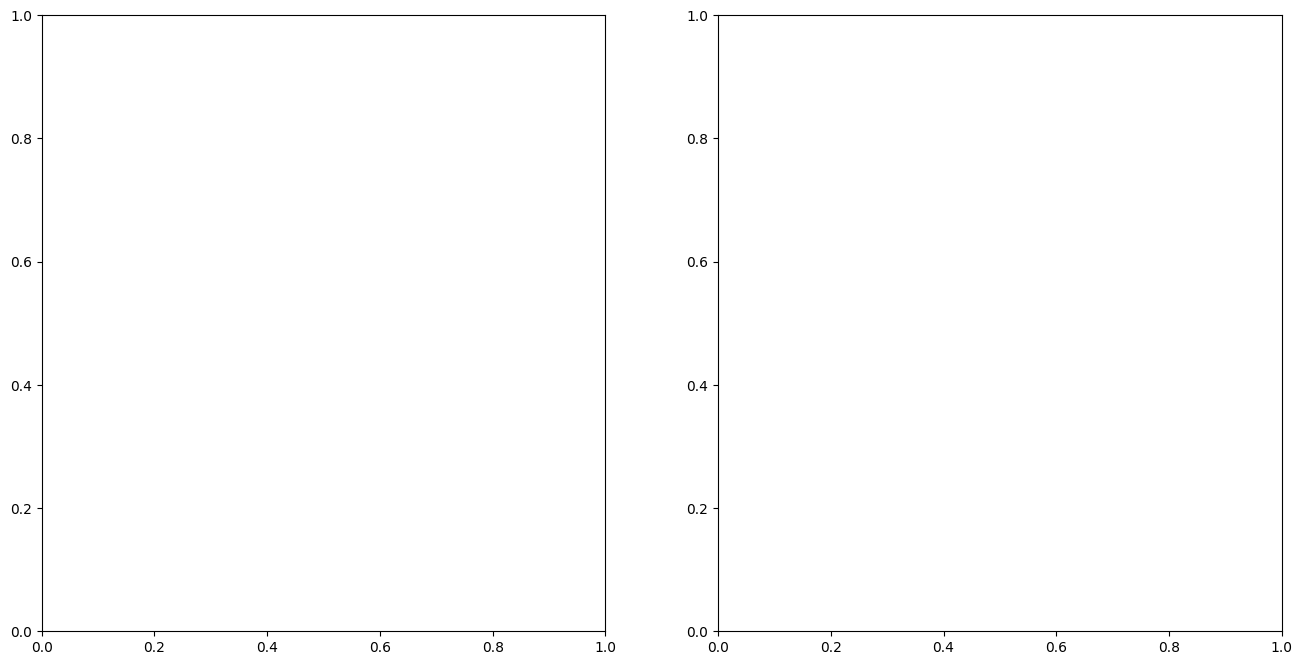

In [20]:
#--------------------------------------------------------------------------------
#------ Flexible multi-case plotter (MIE + ADDA + MSTM): Single Size ------------

# Global defaults inherited by each case unless overridden in the case dict
DEFAULTS = dict(
    comp="comp1",          # "comp1" or "comp2"
    lambda_um=1000,        # 870, 1000, 3000, 7000
    a_V_um=400.0           # target monomer/volume-equivalent radius (µm)
)

# Add/remove/disable cases freely.
# model: "mie" | "adda" | "mstm"
# Optional keys per model:
#   MIE : comp
#   ADDA: porosity ("P_30"... "P_90"), comp
#   MSTM: df ("Df_12"|"Df_21"|"Df_27"), comp
# Common optional keys: lambda_um, a_V_um, label, color, enabled

CASES = [
    {"model": "mie",  "comp": "comp1", "lambda_um": 1000, "a_V_um": 400.0, "label": None, "color": None, "enabled": True},
    {"model": "adda", "porosity": "P_90", "comp": "comp1", "lambda_um": 1000, "a_V_um": 400.0, "label": None, "color": None, "enabled": True},
    {"model": "mstm", "df": "Df_12", "comp": "comp1", "lambda_um": 1000, "a_V_um": 400.0, "label": None, "color": None, "enabled": True},

]

# Plot appearance
LEGEND = True
TITLE_LABEL = False     # passed through to your plot()
NUM_PLOTS = "two"       # whatever your plot() expects ("two" in your code)
COLOR_CYCLE = ["tab:black", "tab:red", "tab:green", "tab:purple", "tab:orange",
               "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]


#------ Helpers -----------------------------------------------------------------
def _df_pretty(df_tag: str) -> str:
    mapping = {"Df_12": "Df=1.2", "Df_21": "Df=2.1", "Df_27": "Df=2.7"}
    return mapping.get(df_tag, df_tag)

def get_mie_case(mie_data, comp, lambda_um, a_V_um):
    key_exact = ("Solid_Sphere", "compact", comp, lambda_um, float(a_V_um))
    if key_exact in mie_data:
        return key_exact, mie_data[key_exact]
    cands = [k for k in mie_data if k[0]=="Solid_Sphere" and k[1]=="compact" and k[2]==comp and k[3]==lambda_um]
    if not cands:
        raise KeyError(f"No MIE data for {comp}, λ={lambda_um} µm.")
    aVs = np.array([k[4] for k in cands], dtype=float)
    idx = int(np.argmin(np.abs(aVs - a_V_um)))
    key = ("Solid_Sphere", "compact", comp, lambda_um, float(aVs[idx]))
    print(f"[INFO][MIE] exact a_V not found. Using {aVs[idx]:.4g} µm (target {a_V_um} µm).")
    return key, mie_data[key]

def get_adda_case(adda_data, porosity, comp, lambda_um, a_V_um):
    key_exact = ("Porous_Sphere", porosity, comp, lambda_um, float(a_V_um))
    if key_exact in adda_data:
        return key_exact, adda_data[key_exact]
    cands = [k for k in adda_data if k[0]=="Porous_Sphere" and k[1]==porosity and k[2]==comp and k[3]==lambda_um]
    if not cands:
        raise KeyError(f"No ADDA data for {porosity}, {comp}, λ={lambda_um} µm.")
    aVs = np.array([k[4] for k in cands], dtype=float)
    idx = int(np.argmin(np.abs(aVs - a_V_um)))
    key = ("Porous_Sphere", porosity, comp, lambda_um, float(aVs[idx]))
    print(f"[INFO][ADDA] exact a_V not found. Using {aVs[idx]:.4g} µm (target {a_V_um} µm).")
    return key, adda_data[key]

def get_mstm_case(mstm_data, df, comp, lambda_um, a_V_um):
    key_exact = ("Fractal_Aggregates", df, comp, lambda_um, float(a_V_um))
    if key_exact in mstm_data:
        return key_exact, mstm_data[key_exact]
    cands = [k for k in mstm_data if k[0]=="Fractal_Aggregates" and k[1]==df and k[2]==comp and k[3]==lambda_um]
    if not cands:
        raise KeyError(f"No MSTM data for {df}, {comp}, λ={lambda_um} µm.")
    aVs = np.array([k[4] for k in cands], dtype=float)
    idx = int(np.argmin(np.abs(aVs - a_V_um)))
    key = ("Fractal_Aggregates", df, comp, lambda_um, float(aVs[idx]))
    print(f"[INFO][MSTM] exact a_V not found. Using {aVs[idx]:.4g} µm (target {a_V_um} µm).")
    return key, mstm_data[key]


#------ Plot --------------------------------------------------------------------
curves_Snorm = []
curves_angles = []
labels = []
colors = []

color_ptr = 0
used_lambdas = []

for case in CASES:
    if case.get("enabled", True) is False:
        continue

    model = case["model"].strip().lower()
    comp = case.get("comp", DEFAULTS["comp"])
    lambda_um = int(case.get("lambda_um", DEFAULTS["lambda_um"]))
    a_V_um = float(case.get("a_V_um", DEFAULTS["a_V_um"]))

    # Pull the data sample per model
    if model == "mie":
        key, sample = get_mie_case(mie_data, comp, lambda_um, a_V_um)
        default_label = f"MIE Solid (a_V={key[4]:.4g} µm)"
    elif model == "adda":
        porosity = case["porosity"]
        key, sample = get_adda_case(adda_data, porosity, comp, lambda_um, a_V_um)
        default_label = f"ADDA {porosity} (a_V={key[4]:.4g} µm)"
    elif model == "mstm":
        df = case["df"]
        key, sample = get_mstm_case(mstm_data, df, comp, lambda_um, a_V_um)
        default_label = f"MSTM {_df_pretty(df)} (a_V={key[4]:.4g} µm)"
    else:
        raise ValueError(f"Unknown model '{model}'. Use 'mie' | 'adda' | 'mstm'.")

    # Normalize & collect
    S = sample["S_matrix"]
    ang = sample["angles"]
    S_norm = normalization_function(S, ang)

    curves_Snorm.append(S_norm)
    curves_angles.append(ang)

    # Label & color
    labels.append(case.get("label") or default_label)
    if case.get("color") is not None:
        colors.append(case["color"])
    else:
        colors.append(COLOR_CYCLE[color_ptr % len(COLOR_CYCLE)])
        color_ptr += 1

    used_lambdas.append(lambda_um)


unique_lams = sorted(set(used_lambdas))
if len(unique_lams) == 0:
    raise RuntimeError("No enabled cases to plot.")
elif len(unique_lams) == 1:
    lam_str = f"λ={unique_lams[0]} µm"
else:
    lam_str = "λ∈{" + ", ".join(str(v) for v in unique_lams) + "} µm"

title = f"Normalized Scattering Matrices — {lam_str} — {len(labels)} case(s)"

# Final plot (uses your existing plot() function & options)
plot(curves_Snorm,
     curves_angles,
     title_label=TITLE_LABEL,
     title=title,
     text=labels,
     color=colors,
     legend=LEGEND,
     num_plots=NUM_PLOTS)

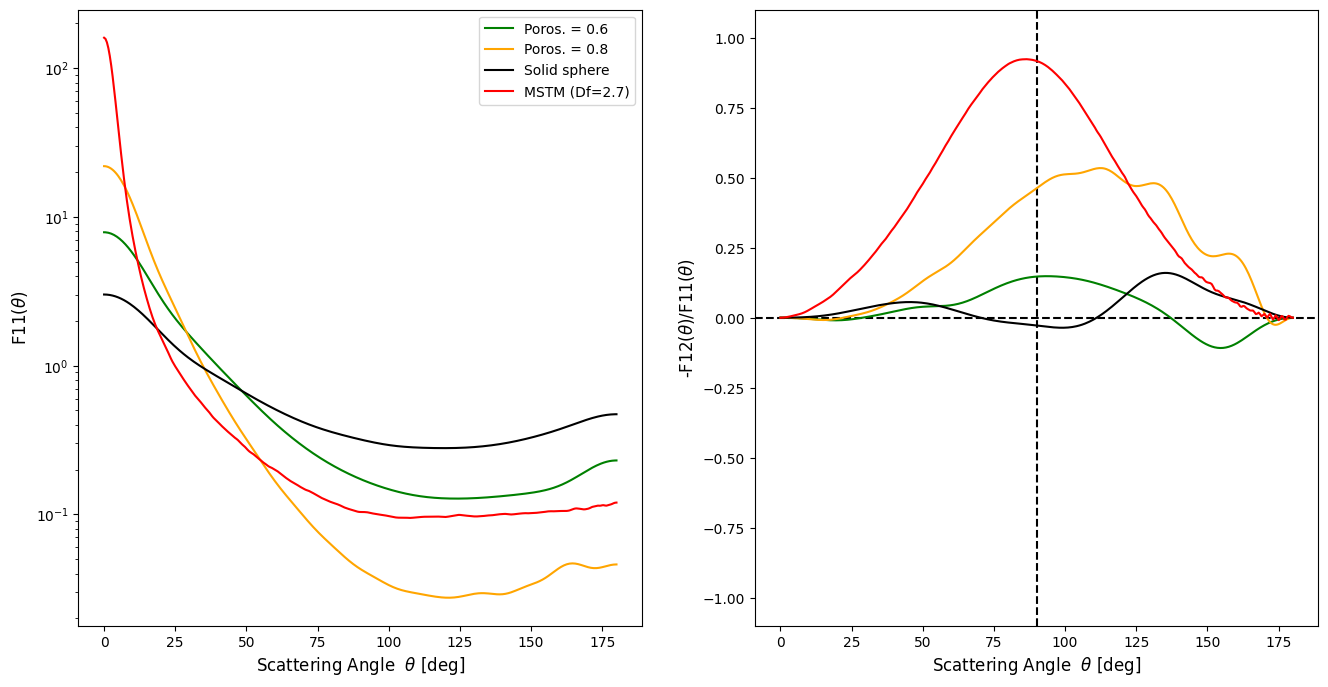

In [11]:
#--------------------------------------------------------------------------------
#------ Flexible multi-case plotter (MIE + ADDA + MSTM): Size Distribution ------

comp       = "comp1"
lambda_um  = 870
alpha      = 3.5
kk_wav     = 2.0*np.pi/float(lambda_um)

# Optional upper clip (mimics your old 1000 µm limit)
A_MAX = 1000.0

# Porosities and colors
porosities  = ["P_60", "P_80"]
poro_colors = {"P_60":"green", "P_80":"orange"}

# ---------- helpers you already have (unchanged) ----------
def _build_subset_adda(adda_data, poro, comp, lambda_um, rr_targets):
    cands = [(k[4], k) for k in adda_data.keys()
             if k[0]=="Porous_Sphere" and k[1]==poro and k[2]==comp and k[3]==lambda_um]
    if not cands:
        return {}, np.array([])
    avail = np.array(sorted({aV for aV, _ in cands}), dtype=float)

    used = set()
    subset = {}
    rr_used = []
    for r in rr_targets:
        idx = int(np.argmin(np.abs(avail - r)))
        aV_sel = float(avail[idx])
        if aV_sel in used:
            continue
        for aV, key in cands:
            if float(aV) == aV_sel:
                subset[key] = adda_data[key]
                rr_used.append(aV_sel)
                used.add(aV_sel)
                break
    return subset, np.array(rr_used, dtype=float)

def _build_subset_mie(mie_data, comp, lambda_um, rr_targets):
    cands = [(k[4], k) for k in mie_data.keys()
             if k[0]=="Solid_Sphere" and k[1]=="compact" and k[2]==comp and k[3]==lambda_um]
    if not cands:
        return {}, np.array([])
    avail = np.array(sorted({aV for aV, _ in cands}), dtype=float)

    used = set()
    subset = {}
    rr_used = []
    for r in rr_targets:
        idx = int(np.argmin(np.abs(avail - r)))
        aV_sel = float(avail[idx])
        if aV_sel in used:
            continue
        for aV, key in cands:
            if float(aV) == aV_sel:
                subset[key] = mie_data[key]
                rr_used.append(aV_sel)
                used.add(aV_sel)
                break
    return subset, np.array(rr_used, dtype=float)

def _build_subset_mstm(mstm_data, df, comp, lambda_um, rr_targets):
    cands = [(k[4], k) for k in mstm_data.keys()
             if k[0]=="Fractal_Aggregates" and k[1]==df and k[2]==comp and k[3]==lambda_um]
    if not cands:
        return {}, np.array([])
    avail = np.array(sorted({aV for aV, _ in cands}), dtype=float)
    aV_max = float(avail.max())

    used = set()
    subset = {}
    rr_used = []
    for r in rr_targets:
        if r > aV_max:
            continue
        idx = int(np.argmin(np.abs(avail - r)))
        aV_sel = float(avail[idx])
        if aV_sel in used:
            continue
        for aV, key in cands:
            if float(aV) == aV_sel:
                subset[key] = mstm_data[key]
                rr_used.append(aV_sel)
                used.add(aV_sel)
                break
    return subset, np.array(rr_used, dtype=float)

# ---------- NEW: build available-size targets directly from datasets ----------
def _available_sizes(dataset, pred, amax_clip=None):
    keys = [k for k in dataset.keys() if pred(k)]
    if not keys:
        return np.array([], dtype=float)
    sizes = np.array(sorted({float(k[4]) for k in keys}), dtype=float)
    if amax_clip is not None:
        sizes = sizes[sizes <= float(amax_clip)]
    return sizes

# Containers for final plot
scamats     = []
angles_list = []
labels      = []
color_list  = []
_used_sizes = []  # to show min–max in title

#-------------------------------------------
# ADDA: size-averaged for each porosity (using available sizes)
for poro in porosities:
    rr_targets_adda = _available_sizes(
        adda_data,
        pred=lambda k: (k[0]=="Porous_Sphere" and k[1]==poro and k[2]==comp and k[3]==lambda_um),
        amax_clip=A_MAX
    )
    if rr_targets_adda.size == 0:
        print(f"[WARN] No ADDA data for {poro}, {comp}, λ={lambda_um} μm.")
        continue

    subset_adda, rr_used = _build_subset_adda(adda_data, poro, comp, lambda_um, rr_targets_adda)
    if not subset_adda or rr_used.size == 0:
        print(f"[WARN] No ADDA subset built for {poro}, {comp}, λ={lambda_um} μm.")
        continue

    angles_adda = next(iter(subset_adda.values()))["angles"]
    PP_SD_adda, *_ = size_distribution(
        data_dict=subset_adda,
        alpha=alpha,
        kk_wav=kk_wav,
        angles=angles_adda,
        rr=rr_used
    )
    PP_SD_adda_norm = normalization_function(PP_SD_adda, angles_adda)

    scamats.append(PP_SD_adda_norm)
    angles_list.append(angles_adda)
    pnum = float(poro.split("_")[1]) / 100.0
    labels.append(f"Poros. = {pnum:.1f}")
    color_list.append(poro_colors.get(poro, "gray"))
    _used_sizes.append(rr_used)

#-------------------------------------------
# MIE: size-averaged using available sizes
rr_targets_mie = _available_sizes(
    mie_data,
    pred=lambda k: (k[0]=="Solid_Sphere" and k[1]=="compact" and k[2]==comp and k[3]==lambda_um),
    amax_clip=A_MAX
)
mie_subset, rr_used_mie = _build_subset_mie(mie_data, comp, lambda_um, rr_targets_mie)
if mie_subset and rr_used_mie.size > 0:
    angles_mie = next(iter(mie_subset.values()))["angles"]
    PP_SD_mie, *_ = size_distribution(
        data_dict=mie_subset,
        alpha=alpha,
        kk_wav=kk_wav,
        angles=angles_mie,
        rr=rr_used_mie
    )
    PP_SD_mie_norm = normalization_function(PP_SD_mie, angles_mie)

    scamats.append(PP_SD_mie_norm)
    angles_list.append(angles_mie)
    labels.append("Solid sphere")
    color_list.append("black")
    _used_sizes.append(rr_used_mie)
else:
    print(f"[WARN] No MIE data for {comp}, λ={lambda_um} μm.")

#-------------------------------------------
# MSTM: size-averaged using available sizes up to its own max
df = "Df_12"  # change if you want another Df
rr_targets_mstm = _available_sizes(
    mstm_data,
    pred=lambda k: (k[0]=="Fractal_Aggregates" and k[1]==df and k[2]==comp and k[3]==lambda_um),
    amax_clip=A_MAX
)
mstm_subset, rr_used_mstm = _build_subset_mstm(mstm_data, df, comp, lambda_um, rr_targets_mstm)
if mstm_subset and rr_used_mstm.size > 0:
    angles_mstm = next(iter(mstm_subset.values()))["angles"]
    PP_SD_mstm, *_ = size_distribution(
        data_dict=mstm_subset,
        alpha=alpha,
        kk_wav=kk_wav,
        angles=angles_mstm,
        rr=rr_used_mstm
    )
    PP_SD_mstm_norm = normalization_function(PP_SD_mstm, angles_mstm)

    scamats.append(PP_SD_mstm_norm)
    angles_list.append(angles_mstm)
    labels.append("MSTM (Df=2.7)")
    color_list.append("red")
    _used_sizes.append(rr_used_mstm)
else:
    print(f"[WARN] No MSTM data for {df}, {comp}, λ={lambda_um} μm.")

#-------------------------------------------
# Title with dynamic size range based on the sizes actually used
if _used_sizes:
    used_concat = np.concatenate([u for u in _used_sizes if u.size > 0])
    amin_used   = np.nanmin(used_concat)
    amax_used   = np.nanmax(used_concat)
    title_txt = (f'DSHARP comp. λ = {lambda_um/1000:.1f} mm, '
                 f'Size Distribution {amin_used:.2f}–{amax_used:.0f} μm ({comp})')
else:
    title_txt = f'DSHARP comp. λ = {lambda_um/1000:.1f} mm, Size Distribution ({comp})'

#-------------------------------------------
# Plot: F11 and −F12/F11 with your existing routine
plot(
    scamats, angles_list,
    title_label=False,
    title=title_txt,
    file_gen=False,
    file_name='Plot_SD_All',
    text=labels,
    color=color_list,
    legend=True,
    num_plots='two'
)

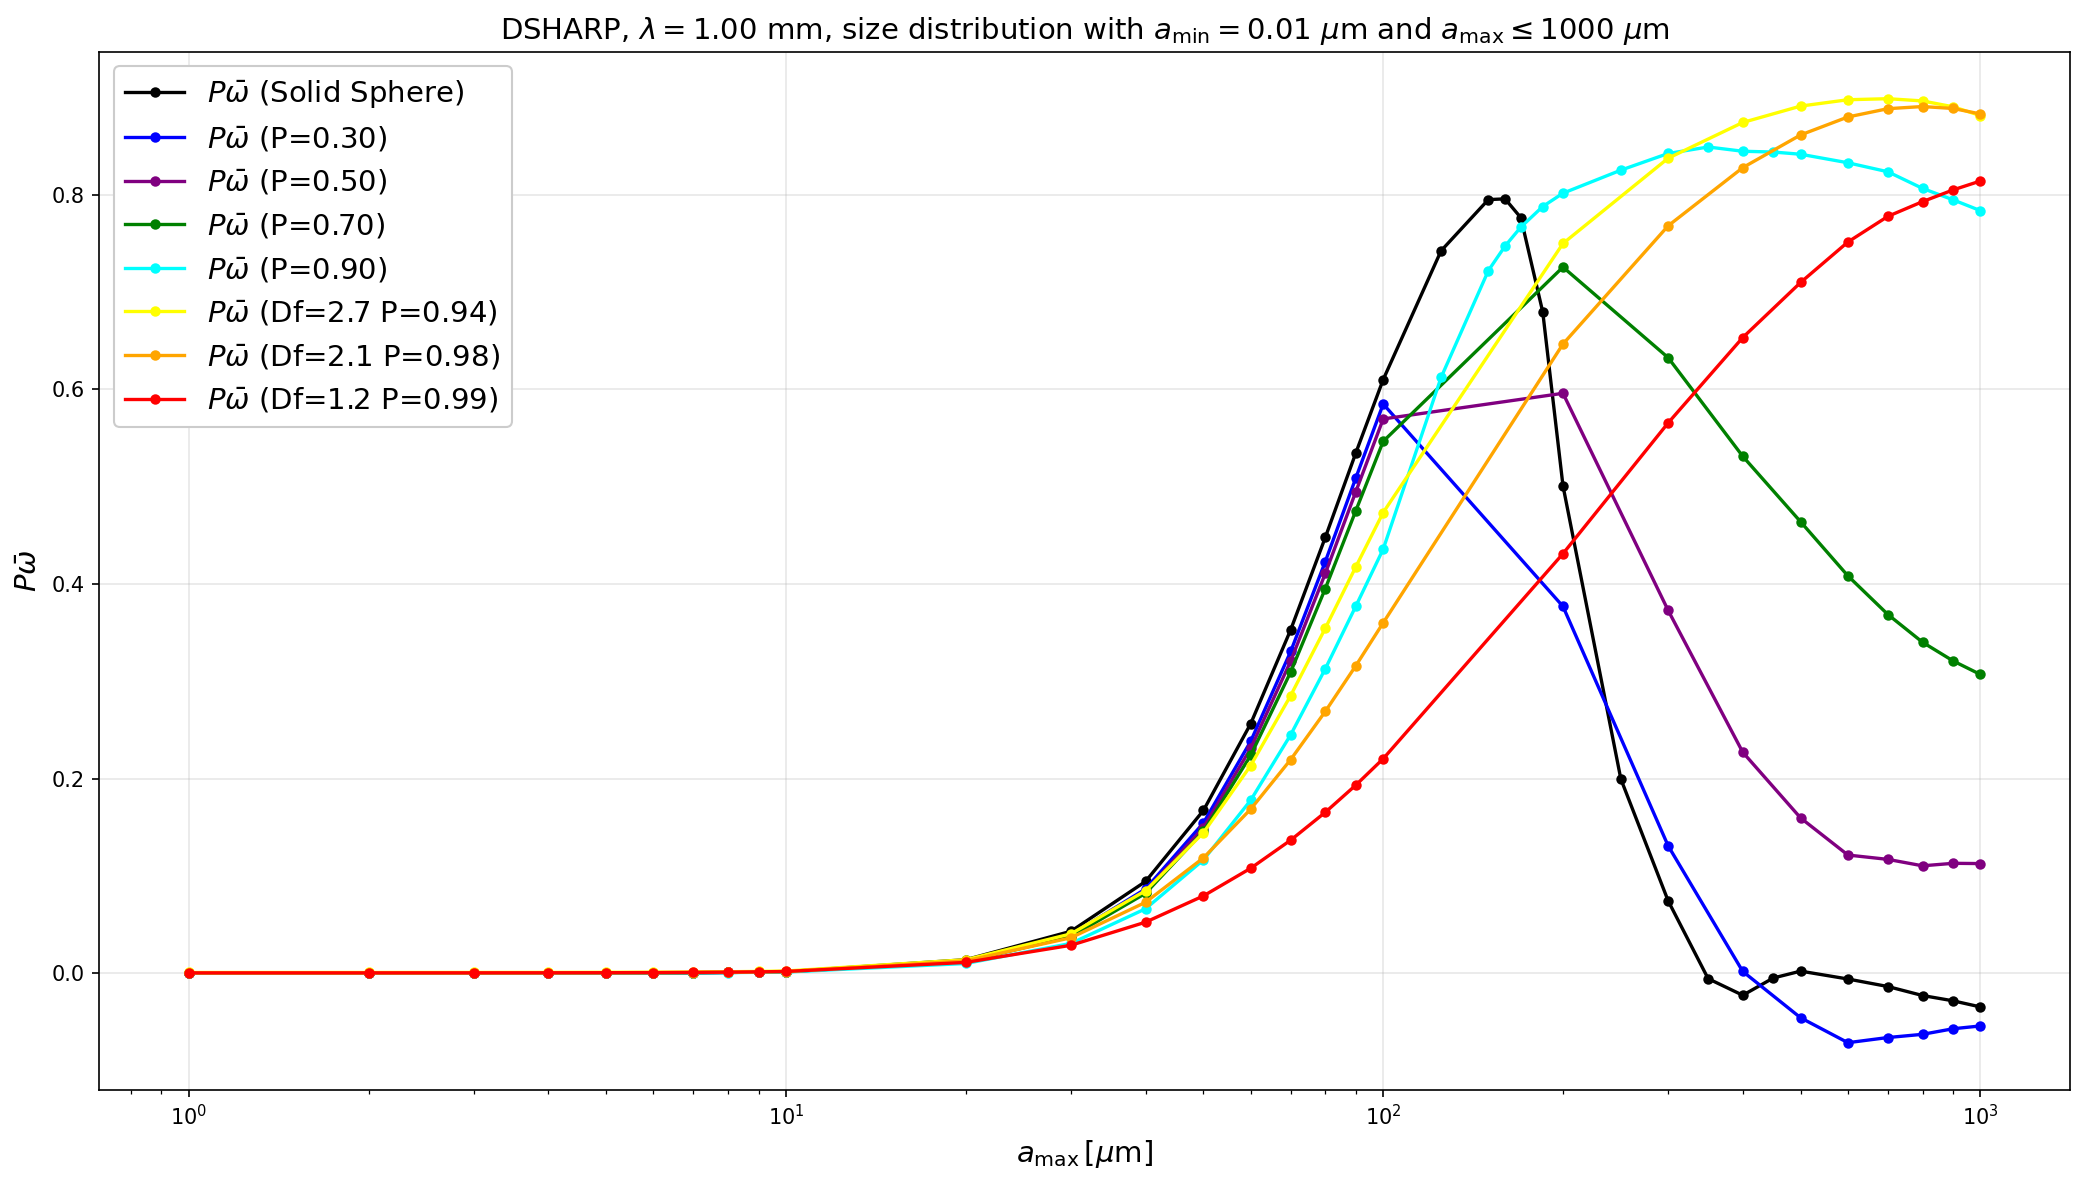

In [12]:
#--------------------------------------------------------------------------------
#------ Single-scattering Albedo * Linear Polarization Fraction Plot ------------
comp       = "comp1"
lambda_um  = 1000
alpha      = 3.5
kk_wav     = 2.0*np.pi/float(lambda_um)

# Optional clamps for the evaluation domain (µm)
A_MIN, A_MAX = 1.0, 1000.0

#------------------------- helpers ---------------------------------------------
def _available_sizes(dataset, pred):
    """Return sorted array of available sizes (µm) and map size->key for entries matching pred(k)."""
    keys = [k for k in dataset.keys() if pred(k)]
    if not keys:
        return np.array([]), {}
    av_to_key = {float(k[4]): k for k in keys}  # assume unique per size
    av_sorted = np.array(sorted(av_to_key.keys()), dtype=float)
    return av_sorted, av_to_key

def _compute_curve(dataset, kind, *, porosity=None, df=None):
    """
    kind ∈ {'ADDA','MIE','MSTM'}.
    For each *available* a_max (from the dataset itself, optionally clamped to [A_MIN, A_MAX]),
    average over all available sizes with a_V <= a_max (no extrapolation).
    """
    if kind == 'ADDA':
        pred = lambda k: (k[0]=="Porous_Sphere" and k[1]==porosity and k[2]==comp and k[3]==lambda_um)
    elif kind == 'MIE':
        pred = lambda k: (k[0]=="Solid_Sphere" and k[1]=="compact" and k[2]==comp and k[3]==lambda_um)
    elif kind == 'MSTM':
        pred = lambda k: (k[0]=="Fractal_Aggregates" and k[1]==df and k[2]==comp and k[3]==lambda_um)
    else:
        raise ValueError("kind debe ser 'ADDA', 'MIE' o 'MSTM'.")

    av_sorted, av_to_key = _available_sizes(dataset, pred)
    if av_sorted.size == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])

    # Evaluate ONLY at sizes that actually exist in the dataset (optionally clamped)
    amax_list = av_sorted[(av_sorted >= A_MIN) & (av_sorted <= A_MAX)]
    if amax_list.size == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])

    x_amax, P90_list, alb_list, PAlb_list = [], [], [], []
    for amax in amax_list:
        rr_used = av_sorted[av_sorted <= float(amax)]
        if rr_used.size == 0:
            continue

        subset = {av_to_key[aV]: dataset[av_to_key[aV]] for aV in rr_used}
        angles = next(iter(subset.values()))["angles"]

        PP_SD, _, _, _, _, albedo, *_ = size_distribution(
            data_dict=subset,
            alpha=alpha,
            kk_wav=kk_wav,
            angles=angles,
            rr=rr_used
        )
        PP_SD_N = normalization_function(PP_SD, angles)
        j90 = int(np.argmin(np.abs(angles - 90.0)))
        P90 = -PP_SD_N[j90, 1] / PP_SD_N[j90, 0]

        x_amax.append(float(amax))
        P90_list.append(P90)
        alb_list.append(albedo)
        PAlb_list.append(P90 * albedo)

    return (np.array(x_amax, dtype=float),
            np.array(P90_list, dtype=float),
            np.array(alb_list, dtype=float),
            np.array(PAlb_list, dtype=float))

#----------------------- curves to compute -------------------------------------
curves_cfg = [
    ("MIE",  {},                  dict(color="black",   label_base="Solid Sphere")),
    ("ADDA", {"porosity":"P_30"}, dict(color="blue",    label_base="P=0.30")),
    ("ADDA", {"porosity":"P_50"}, dict(color="purple",  label_base="P=0.50")),
    ("ADDA", {"porosity":"P_70"}, dict(color="green",   label_base="P=0.70")),
    ("ADDA", {"porosity":"P_90"}, dict(color="cyan",    label_base="P=0.90")),
    ("MSTM", {"df":"Df_27"},      dict(color="yellow",  label_base="Df=2.7 P=0.94")),
    ("MSTM", {"df":"Df_21"},      dict(color="orange",  label_base="Df=2.1 P=0.98")),
    ("MSTM", {"df":"Df_12"},      dict(color="red",     label_base="Df=1.2 P=0.99")),
]

results = []
for kind, params, style in curves_cfg:
    xa, P90, alb, peff = _compute_curve(
        {'ADDA': adda_data, 'MIE': mie_data, 'MSTM': mstm_data}[kind],
        kind,
        **params
    )
    results.append((kind, params, style, xa, P90, alb, peff))

#----------------------------- plot --------------------------------------------
fig = plt.figure(figsize=(14, 8), dpi=150)
fig.patch.set_facecolor('white')
plt.semilogx()

# Draw: P·ω̄ (solid), ω̄ (dotted), P(90°) (dashed)  — keep as you prefer
for kind, params, style, xa, P90, alb, peff in results:
    if xa.size == 0:
        continue
    base = style.get("label_base", kind)
    c    = style.get("color", "gray")
    plt.plot(xa, peff, '-',  marker='o',  ms=4, lw=1.6, color=c, label=rf'$P\bar{{\omega}}$ ({base})')
    # plt.plot(xa, alb,  ':',  lw=1.4, color=c, alpha=0.8, label=rf'$\bar{{\omega}}$ ({base})')
    # plt.plot(xa, P90,  '--', lw=1.4, color=c, alpha=0.9, label=rf'$P(90^\circ)$ ({base})')

plt.xlabel(r'$a_{\rm max}\,[\mu{\rm m}]$', fontsize=14)
plt.ylabel(r'$P\bar{\omega}$', fontsize=14)
plt.title(rf'DSHARP, $\lambda={lambda_um/1000:.2f}\ \mathrm{{mm}}$, '
          rf'size distribution with $a_{{\rm min}}=0.01~\mu\mathrm{{m}}$ and $a_{{\rm max}}\leq {A_MAX:.0f}~\mu\mathrm{{m}}$',
          fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, ncol=1, framealpha=1)
plt.tight_layout()
plt.show()

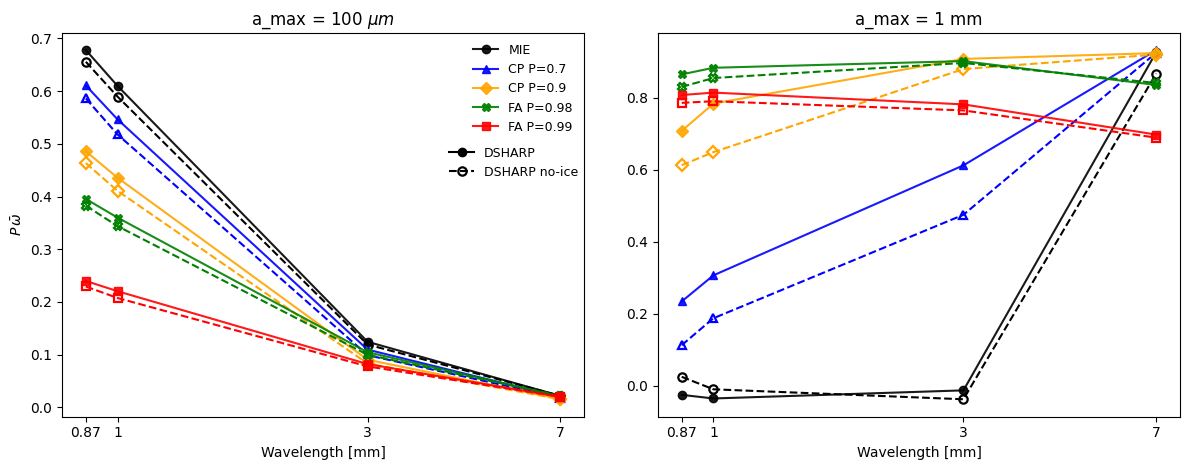

In [16]:
#--------------------------------------------------------------------------------
#------ Spectral behaviour of Albedo * Polarization Plot ------------------------

ALPHA_SD = 3.5
WAVELENGTHS_UM = [870, 1000, 3000, 7000]           # μm
WAVELENGTHS_MM = np.array(WAVELENGTHS_UM) / 1000.0 # mm (x-axis)
AV_MAX_LIST   = [100, 1000]                        # μm → left, right subplots (in this order)
IDX_WL_1MM    = WAVELENGTHS_UM.index(1000)         # index of λ = 1 mm

# Plot both compositions; comp1=DSHARP, comp2=DSHARP no-ice
COMPS           = ["comp1", "comp2"]
COMP_LINESTYLE  = {"comp1": "-",  "comp2": "--"}   # solid for comp1, dashed for comp2
COMP_ALPHA      = {"comp1": 0.9,  "comp2": 1.0}

# ---- Series to plot (ORDERED) ----
# MIE, P=0.7, P=0.9, FA P≈0.98 (Df=2.1), FA P≈0.99 (Df=1.2)
# colors: black, blue, orange, green, red
# markers: "o", "^", "D", "P", "s" respectively
SERIES = [
    ("mie",  None, "MIE",          "black",  "o"),
    ("adda", 0.7,  "CP P=0.7",     "blue",   "^"),
    ("adda", 0.9,  "CP P=0.9",     "orange", "D"),
    ("mstm", 2.1,  "FA P=0.98",    "green",  "X"),  # Df=2.1 ~ P≈0.98
    ("mstm", 1.2,  "FA P=0.99",    "red",    "s"),  # Df=1.2 ~ P≈0.99
]

# (Optional) y-limits per panel (None → autoscale). Keys must match AV_MAX_LIST.
YLIMS_BY_AVMAX = {
    100:  None,       # e.g., (1e-4, 0.2)
    1000: None,       # e.g., (2e-5, 0.05)
}

# --------- Helpers to discover available a_max (μm) per dataset ---------
def _available_sizes(dataset, pred, amax_clip=None):
    keys = [k for k in dataset.keys() if pred(k)]
    if not keys:
        return np.array([], dtype=float)
    sizes = np.array(sorted({float(k[4]) for k in keys}), dtype=float)
    if amax_clip is not None:
        sizes = sizes[sizes <= float(amax_clip)]
    return sizes

def _build_subset_mie(mie_data, comp, lambda_um, rr_targets):
    cands = [(k[4], k) for k in mie_data.keys()
             if (k[0]=="Solid_Sphere" and k[1]=="compact" and k[2]==comp and k[3]==lambda_um)]
    if not cands: return {}, np.array([])
    avail = np.array(sorted({aV for aV,_ in cands}), dtype=float)
    used, subset, rr_used = set(), {}, []
    for r in rr_targets:
        idx = int(np.argmin(np.abs(avail - r))); aV_sel = float(avail[idx])
        if aV_sel in used: continue
        for aV, key in cands:
            if float(aV) == aV_sel:
                subset[key] = mie_data[key]; rr_used.append(aV_sel); used.add(aV_sel); break
    return subset, np.array(rr_used, dtype=float)

def _build_subset_adda(adda_data, poro, comp, lambda_um, rr_targets):
    cands = [(k[4], k) for k in adda_data.keys()
             if (k[0]=="Porous_Sphere" and k[1]==poro and k[2]==comp and k[3]==lambda_um)]
    if not cands: return {}, np.array([])
    avail = np.array(sorted({aV for aV,_ in cands}), dtype=float)
    used, subset, rr_used = set(), {}, []
    for r in rr_targets:
        idx = int(np.argmin(np.abs(avail - r))); aV_sel = float(avail[idx])
        if aV_sel in used: continue
        for aV, key in cands:
            if float(aV) == aV_sel:
                subset[key] = adda_data[key]; rr_used.append(aV_sel); used.add(aV_sel); break
    return subset, np.array(rr_used, dtype=float)

def _build_subset_mstm(mstm_data, df, comp, lambda_um, rr_targets):
    cands = [(k[4], k) for k in mstm_data.keys()
             if (k[0]=="Fractal_Aggregates" and k[1]==df and k[2]==comp and k[3]==lambda_um)]
    if not cands: return {}, np.array([])
    avail = np.array(sorted({aV for aV,_ in cands}), dtype=float)
    used, subset, rr_used = set(), {}, []
    for r in rr_targets:
        if r < avail.min() or r > avail.max(): continue
        idx = int(np.argmin(np.abs(avail - r))); aV_sel = float(avail[idx])
        if aV_sel in used: continue
        for aV, key in cands:
            if float(aV) == aV_sel:
                subset[key] = mstm_data[key]; rr_used.append(aV_sel); used.add(aV_sel); break
    return subset, np.array(rr_used, dtype=float)

# ------------------------------------------------------
# Core: compute P(90°) × albedo for one (case, comp, wl)
# ------------------------------------------------------
def _pol_eff_value(family, param, comp, wl_um, aV_max):
    if family == "mie":
        rr_targets = _available_sizes(
            mie_data, pred=lambda k: (k[0]=="Solid_Sphere" and k[1]=="compact" and k[2]==comp and k[3]==wl_um),
            amax_clip=aV_max
        )
        subset, rr_used = _build_subset_mie(mie_data, comp, wl_um, rr_targets)

    elif family == "adda":
        poro = f"P_{int(round(param*100))}"   # e.g., 0.7 → "P_70"
        rr_targets = _available_sizes(
            adda_data, pred=lambda k: (k[0]=="Porous_Sphere" and k[1]==poro and k[2]==comp and k[3]==wl_um),
            amax_clip=aV_max
        )
        subset, rr_used = _build_subset_adda(adda_data, poro, comp, wl_um, rr_targets)

    elif family == "mstm":
        df = f"Df_{int(round(param*10))}"     # e.g., 1.2 → "Df_12"
        rr_targets = _available_sizes(
            mstm_data, pred=lambda k: (k[0]=="Fractal_Aggregates" and k[1]==df and k[2]==comp and k[3]==wl_um),
            amax_clip=aV_max
        )
        subset, rr_used = _build_subset_mstm(mstm_data, df, comp, wl_um, rr_targets)
    else:
        return np.nan

    if not subset or rr_used.size == 0:
        return np.nan

    angles = next(iter(subset.values()))["angles"]
    kk     = 2.0 * np.pi / float(wl_um)
    out    = size_distribution(data_dict=subset, alpha=ALPHA_SD, kk_wav=kk, angles=angles, rr=rr_used)
    PP_SD, albedo = out[0], out[5]  # convention: PP_SD, _, _, _, _, albedo, *_
    PP_SD_N = normalization_function(PP_SD, angles)
    j90 = int(np.argmin(np.abs(angles - 90.0)))
    P90 = -PP_SD_N[j90, 1] / PP_SD_N[j90, 0]
    return float(P90 * albedo)

def _amax_title(aV_max_um):
    return "a_max = 1 mm" if int(aV_max_um) == 1000 else rf"a_max = {aV_max_um} $\mu m$"

# -----------------------
# Compute and plot panels
# -----------------------
# Build quick access dicts from SERIES
SERIES_KEYS     = [(fam, prm) for fam, prm, *_ in SERIES]
SERIES_LABELS   = {(fam, prm): lbl   for fam, prm, lbl, *_ in SERIES}
SERIES_COLORS   = {(fam, prm): color for fam, prm, _,  color, _ in SERIES}
SERIES_MARKERS  = {(fam, prm): mk    for fam, prm, *_ , mk in SERIES}

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))  # independent y-range per subplot

for ax, aV_max in zip(axes, AV_MAX_LIST):
    is_first_panel = (ax is axes[0])

    for fam, prm in SERIES_KEYS:
        label = SERIES_LABELS[(fam, prm)]
        color = SERIES_COLORS[(fam, prm)]
        mark  = SERIES_MARKERS[(fam, prm)]

        for comp in COMPS:
            # compute values across wavelengths
            vals = np.array([_pol_eff_value(fam, prm, comp, wl, aV_max) for wl in WAVELENGTHS_UM], dtype=float)

            # --- Manual override example kept (adjust if needed)
            if (fam == "mstm") and (abs(prm - 1.2) < 1e-9) and (comp == "comp2") and (int(aV_max) == 1000):
                vals[IDX_WL_1MM] = 0.79

            if np.all(np.isnan(vals)):
                continue

            # ---- composition-based marker fill: comp1 filled, comp2 hollow ----
            mface = color if comp == "comp1" else 'none'
            medge = color
            mew   = 1.0 if comp == "comp1" else 1.6

            ax.plot(
                WAVELENGTHS_MM, vals,
                linestyle=COMP_LINESTYLE[comp],
                alpha=COMP_ALPHA[comp],
                marker=mark, markersize=6,
                color=color,
                markerfacecolor=mface,
                markeredgecolor=medge,
                markeredgewidth=mew,
                label=(label if is_first_panel else None)
            )

    # X-axis: log, ONLY the specified wavelengths, 3-digit format, no scientific notation
    ax.set_xscale("log")
    ax.xaxis.set_major_locator(FixedLocator(WAVELENGTHS_MM))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3g}"))
    ax.xaxis.set_minor_locator(NullLocator())
    ax.set_xlabel(r"Wavelength [mm]")
    ax.set_title(_amax_title(aV_max))
    ax.grid(False)

    # Optional y-limits per panel
    ylims = YLIMS_BY_AVMAX.get(aV_max, None)
    if ylims is not None:
        ax.set_ylim(*ylims)

# Y-label on the left subplot
axes[0].set_ylabel(r"$P\,\bar{\omega}$")

# ------- Legends on first subplot only (keep both) -------
ax0 = axes[0]

# (A) Series legend (colors/markers; deduplicate labels)
handles, labels = ax0.get_legend_handles_labels()
seen, h_ord, l_ord = set(), [], []
for h, l in zip(handles, labels):
    if l and (l not in seen):
        seen.add(l); h_ord.append(h); l_ord.append(l)
if h_ord:
    leg_series = ax0.legend(h_ord, l_ord, loc="upper right", fontsize=9, frameon=False)
    ax0.add_artist(leg_series)  # keep the series legend when adding the style legend

# (B) Composition/style legend using filled vs hollow markers (and matching line styles)
style_handles = [
    Line2D([0], [0], linestyle=COMP_LINESTYLE["comp1"], color="black",
           marker="o", markersize=6, markerfacecolor="black", markeredgecolor="black",
           label="DSHARP"),
    Line2D([0], [0], linestyle=COMP_LINESTYLE["comp2"], color="black",
           marker="o", markersize=6, markerfacecolor="none", markeredgecolor="black", markeredgewidth=1.6,
           label="DSHARP no-ice"),
]
ax0.legend(style_handles, [h.get_label() for h in style_handles],
           loc="lower left", bbox_to_anchor=(0.72, 0.59), fontsize=9, frameon=False)

fig.tight_layout()
plt.show()
#fig.savefig("plot_xx.png", dpi=600, bbox_inches="tight")

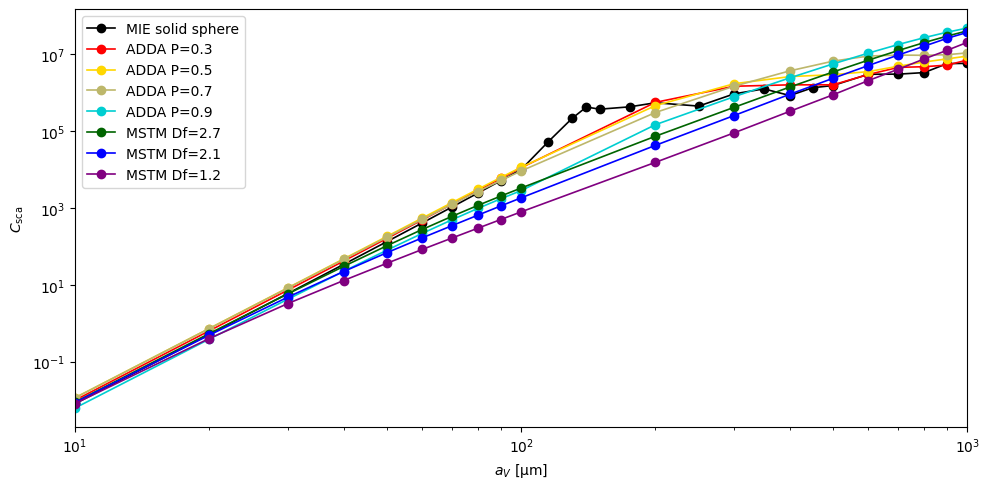

In [17]:
#-------------------------------------------------------------------------------
#------ Scattering Cross-sections ----------------------------------------------
wav_input = 870
mie_comp       = "comp1"
mie_lambda_um  = wav_input

adda_comp      = "comp1"
adda_lambda_um = wav_input

mstm_comp      = "comp1"
mstm_lambda_um = wav_input

# One or more among: "C_sca", "C_abs", "C_ext"
# (Legend is per-model; Y-label reflects the first quantity)
quantities = ["C_sca"]

aV_min = 10
aV_max = 1000

# Text for y-axis
q_tex = {"C_sca": r"$C_{\rm sca}$", "C_abs": r"$C_{\rm abs}$", "C_ext": r"$C_{\rm ext}$"}

# ---------- ORDER you requested ----------
adda_por_order = ["P_30", "P_50", "P_70", "P_90"]          # 0.3, 0.5, 0.7, 0.9
mstm_df_order  = ["Df_27", "Df_21", "Df_12"]               # 2.7, 2.1, 1.2

# Colors per series (feel free to tweak)
series_colors = {
    "MIE solid sphere": "black",
    "ADDA P=0.3": "red",
    "ADDA P=0.5": "gold",
    "ADDA P=0.7": "darkkhaki",
    "ADDA P=0.9": "darkturquoise",
    "MSTM Df=2.7": "darkgreen",
    "MSTM Df=2.1": "blue",
    "MSTM Df=1.2": "purple",
}

# Line style (no markers, dashed only)
linewidth = 1.2
line_kwargs = dict(ls="-", marker='o', linewidth=linewidth)

# Data families (must exist from your previous cells)
# mie_data, adda_data, mstm_data
family_dict = {"mie": mie_data, "adda": adda_data, "mstm": mstm_data}

# Auto title
plot_title = (f"Cross-sections vs $a_V$ — "
              f"MIE(λ={mie_lambda_um} μm), ADDA(λ={adda_lambda_um} μm), MSTM(λ={mstm_lambda_um} μm)")


plt.figure(figsize=(10, 5))

# ---------- 1) MIE: Solid sphere ----------
# keys: (family, subtype, comp, lambda_um, aV)
# expected: ("Solid_Sphere", "compact", mie_comp, mie_lambda_um, aV)
pairs = [(k[4], v) for k, v in family_dict["mie"].items()
         if (k[0] == "Solid_Sphere" and k[1] == "compact"
             and k[2] == mie_comp and k[3] == mie_lambda_um)]
pairs.sort(key=lambda t: t[0])

if not pairs:
    print(f"[INFO] No MIE data found for λ={mie_lambda_um} μm, {mie_comp}. Skipping.")
else:
    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for MIE {q}.")
        else:
            plt.plot(aV_plot, y_plot,
                     color=series_colors["MIE solid sphere"],
                     label="MIE solid sphere",
                     **line_kwargs)

# ---------- 2) ADDA: Porous spheres in required order ----------
for por in adda_por_order:
    pairs = [(k[4], v) for k, v in family_dict["adda"].items()
             if (k[0] == "Porous_Sphere" and k[1] == por
                 and k[2] == adda_comp and k[3] == adda_lambda_um)]
    pairs.sort(key=lambda t: t[0])

    phi = int(por.split("_")[1]) / 100.0  # e.g., P_30 -> 0.3
    label_txt = f"ADDA P={phi:.1f}"

    if not pairs:
        print(f"[INFO] No ADDA data for λ={adda_lambda_um} μm, {por}, {adda_comp}. Skipping.")
        continue

    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for {label_txt} {q}.")
            continue

        plt.plot(aV_plot, y_plot,
                 color=series_colors[label_txt],
                 label=label_txt,
                 **line_kwargs)

# ---------- 3) MSTM: Fractal aggregates in required order ----------
for df in mstm_df_order:
    pairs = [(k[4], v) for k, v in family_dict["mstm"].items()
             if (k[0] == "Fractal_Aggregates" and k[1] == df
                 and k[2] == mstm_comp and k[3] == mstm_lambda_um)]
    pairs.sort(key=lambda t: t[0])

    df_val = float(df.split("_")[1]) / 10.0  # e.g., Df_27 -> 2.7
    label_txt = f"MSTM Df={df_val:.1f}"

    if not pairs:
        print(f"[INFO] No MSTM data for λ={mstm_lambda_um} μm, {df}, {mstm_comp}. Skipping.")
        continue

    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for {label_txt} {q}.")
            continue

        plt.plot(aV_plot, y_plot,
                 color=series_colors[label_txt],
                 label=label_txt,
                 **line_kwargs)

# ---------- Cosmetics ----------
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$a_V\ \mathrm{[\mu m]}$')
ylabel_txt = q_tex.get(quantities[0], quantities[0])
plt.ylabel(ylabel_txt)
plt.grid(False)
plt.legend(ncol=1, fontsize=10)

# Respect explicit aV bounds in both data filtering and axis limits
if (aV_min is not None) or (aV_max is not None):
    xmin, xmax = plt.xlim()
    if aV_min is not None: xmin = aV_min
    if aV_max is not None: xmax = aV_max
    plt.xlim(xmin, xmax)

plt.tight_layout()
plt.show()

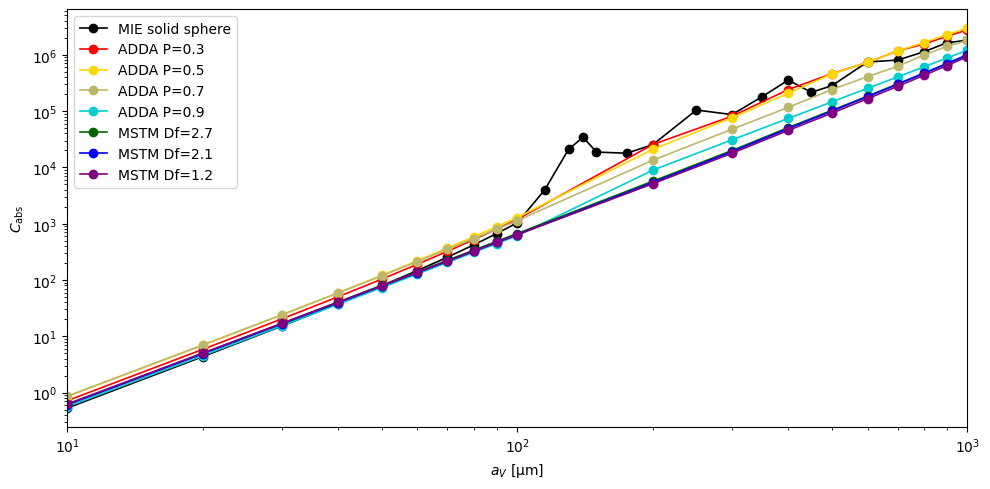

In [18]:
#-------------------------------------------------------------------------------
#------ Absorption Cross-sections ----------------------------------------------
wav_input = 870
mie_comp       = "comp1"
mie_lambda_um  = wav_input

adda_comp      = "comp1"
adda_lambda_um = wav_input

mstm_comp      = "comp1"
mstm_lambda_um = wav_input

# One or more among: "C_sca", "C_abs", "C_ext"
# (Legend is per-model; Y-label reflects the first quantity)
quantities = ["C_abs"]

aV_min = 10
aV_max = 1000

# Text for y-axis
q_tex = {"C_sca": r"$C_{\rm sca}$", "C_abs": r"$C_{\rm abs}$", "C_ext": r"$C_{\rm ext}$"}

# ---------- ORDER you requested ----------
adda_por_order = ["P_30", "P_50", "P_70", "P_90"]          # 0.3, 0.5, 0.7, 0.9
mstm_df_order  = ["Df_27", "Df_21", "Df_12"]               # 2.7, 2.1, 1.2

# Colors per series (feel free to tweak)
series_colors = {
    "MIE solid sphere": "black",
    "ADDA P=0.3": "red",
    "ADDA P=0.5": "gold",
    "ADDA P=0.7": "darkkhaki",
    "ADDA P=0.9": "darkturquoise",
    "MSTM Df=2.7": "darkgreen",
    "MSTM Df=2.1": "blue",
    "MSTM Df=1.2": "purple",
}

# Line style (no markers, dashed only)
linewidth = 1.2
line_kwargs = dict(ls="-", marker='o', linewidth=linewidth)

# Data families (must exist from your previous cells)
# mie_data, adda_data, mstm_data
family_dict = {"mie": mie_data, "adda": adda_data, "mstm": mstm_data}

# Auto title
plot_title = (f"Cross-sections vs $a_V$ — "
              f"MIE(λ={mie_lambda_um} μm), ADDA(λ={adda_lambda_um} μm), MSTM(λ={mstm_lambda_um} μm)")


plt.figure(figsize=(10, 5))

# ---------- 1) MIE: Solid sphere ----------
# keys: (family, subtype, comp, lambda_um, aV)
# expected: ("Solid_Sphere", "compact", mie_comp, mie_lambda_um, aV)
pairs = [(k[4], v) for k, v in family_dict["mie"].items()
         if (k[0] == "Solid_Sphere" and k[1] == "compact"
             and k[2] == mie_comp and k[3] == mie_lambda_um)]
pairs.sort(key=lambda t: t[0])

if not pairs:
    print(f"[INFO] No MIE data found for λ={mie_lambda_um} μm, {mie_comp}. Skipping.")
else:
    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for MIE {q}.")
        else:
            plt.plot(aV_plot, y_plot,
                     color=series_colors["MIE solid sphere"],
                     label="MIE solid sphere",
                     **line_kwargs)

# ---------- 2) ADDA: Porous spheres in required order ----------
for por in adda_por_order:
    pairs = [(k[4], v) for k, v in family_dict["adda"].items()
             if (k[0] == "Porous_Sphere" and k[1] == por
                 and k[2] == adda_comp and k[3] == adda_lambda_um)]
    pairs.sort(key=lambda t: t[0])

    phi = int(por.split("_")[1]) / 100.0  # e.g., P_30 -> 0.3
    label_txt = f"ADDA P={phi:.1f}"

    if not pairs:
        print(f"[INFO] No ADDA data for λ={adda_lambda_um} μm, {por}, {adda_comp}. Skipping.")
        continue

    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for {label_txt} {q}.")
            continue

        plt.plot(aV_plot, y_plot,
                 color=series_colors[label_txt],
                 label=label_txt,
                 **line_kwargs)

# ---------- 3) MSTM: Fractal aggregates in required order ----------
for df in mstm_df_order:
    pairs = [(k[4], v) for k, v in family_dict["mstm"].items()
             if (k[0] == "Fractal_Aggregates" and k[1] == df
                 and k[2] == mstm_comp and k[3] == mstm_lambda_um)]
    pairs.sort(key=lambda t: t[0])

    df_val = float(df.split("_")[1]) / 10.0  # e.g., Df_27 -> 2.7
    label_txt = f"MSTM Df={df_val:.1f}"

    if not pairs:
        print(f"[INFO] No MSTM data for λ={mstm_lambda_um} μm, {df}, {mstm_comp}. Skipping.")
        continue

    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for {label_txt} {q}.")
            continue

        plt.plot(aV_plot, y_plot,
                 color=series_colors[label_txt],
                 label=label_txt,
                 **line_kwargs)

# ---------- Cosmetics ----------
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$a_V\ \mathrm{[\mu m]}$')
ylabel_txt = q_tex.get(quantities[0], quantities[0])
plt.ylabel(ylabel_txt)
plt.grid(False)
plt.legend(ncol=1, fontsize=10)

# Respect explicit aV bounds in both data filtering and axis limits
if (aV_min is not None) or (aV_max is not None):
    xmin, xmax = plt.xlim()
    if aV_min is not None: xmin = aV_min
    if aV_max is not None: xmax = aV_max
    plt.xlim(xmin, xmax)

plt.tight_layout()
plt.show()

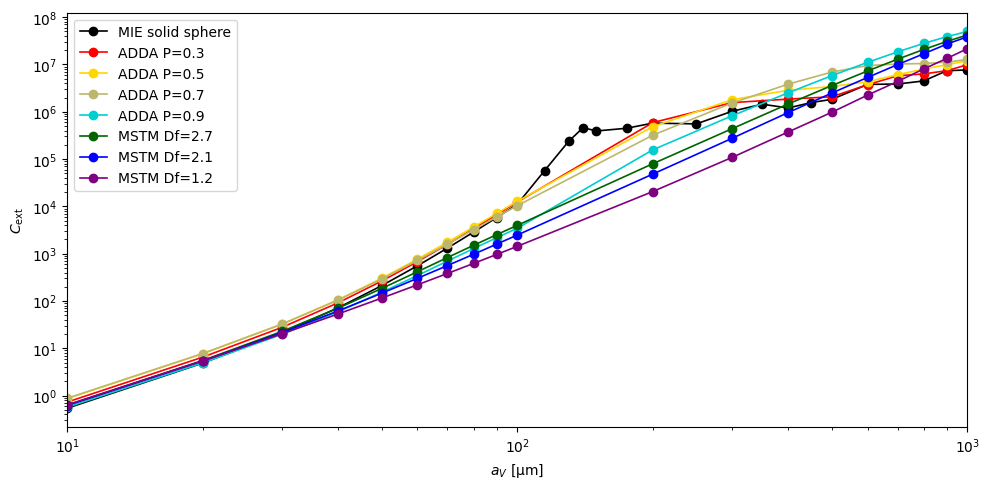

In [19]:
#-------------------------------------------------------------------------------
#------ Extinction Cross-sections ----------------------------------------------
wav_input = 870
mie_comp       = "comp1"
mie_lambda_um  = wav_input

adda_comp      = "comp1"
adda_lambda_um = wav_input

mstm_comp      = "comp1"
mstm_lambda_um = wav_input

# One or more among: "C_sca", "C_abs", "C_ext"
# (Legend is per-model; Y-label reflects the first quantity)
quantities = ["C_ext"]

aV_min = 10
aV_max = 1000

# Text for y-axis
q_tex = {"C_sca": r"$C_{\rm sca}$", "C_abs": r"$C_{\rm abs}$", "C_ext": r"$C_{\rm ext}$"}

# ---------- ORDER you requested ----------
adda_por_order = ["P_30", "P_50", "P_70", "P_90"]          # 0.3, 0.5, 0.7, 0.9
mstm_df_order  = ["Df_27", "Df_21", "Df_12"]               # 2.7, 2.1, 1.2

# Colors per series (feel free to tweak)
series_colors = {
    "MIE solid sphere": "black",
    "ADDA P=0.3": "red",
    "ADDA P=0.5": "gold",
    "ADDA P=0.7": "darkkhaki",
    "ADDA P=0.9": "darkturquoise",
    "MSTM Df=2.7": "darkgreen",
    "MSTM Df=2.1": "blue",
    "MSTM Df=1.2": "purple",
}

# Line style (no markers, dashed only)
linewidth = 1.2
line_kwargs = dict(ls="-", marker='o', linewidth=linewidth)

# Data families (must exist from your previous cells)
# mie_data, adda_data, mstm_data
family_dict = {"mie": mie_data, "adda": adda_data, "mstm": mstm_data}

# Auto title
plot_title = (f"Cross-sections vs $a_V$ — "
              f"MIE(λ={mie_lambda_um} μm), ADDA(λ={adda_lambda_um} μm), MSTM(λ={mstm_lambda_um} μm)")


plt.figure(figsize=(10, 5))

# ---------- 1) MIE: Solid sphere ----------
# keys: (family, subtype, comp, lambda_um, aV)
# expected: ("Solid_Sphere", "compact", mie_comp, mie_lambda_um, aV)
pairs = [(k[4], v) for k, v in family_dict["mie"].items()
         if (k[0] == "Solid_Sphere" and k[1] == "compact"
             and k[2] == mie_comp and k[3] == mie_lambda_um)]
pairs.sort(key=lambda t: t[0])

if not pairs:
    print(f"[INFO] No MIE data found for λ={mie_lambda_um} μm, {mie_comp}. Skipping.")
else:
    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for MIE {q}.")
        else:
            plt.plot(aV_plot, y_plot,
                     color=series_colors["MIE solid sphere"],
                     label="MIE solid sphere",
                     **line_kwargs)

# ---------- 2) ADDA: Porous spheres in required order ----------
for por in adda_por_order:
    pairs = [(k[4], v) for k, v in family_dict["adda"].items()
             if (k[0] == "Porous_Sphere" and k[1] == por
                 and k[2] == adda_comp and k[3] == adda_lambda_um)]
    pairs.sort(key=lambda t: t[0])

    phi = int(por.split("_")[1]) / 100.0  # e.g., P_30 -> 0.3
    label_txt = f"ADDA P={phi:.1f}"

    if not pairs:
        print(f"[INFO] No ADDA data for λ={adda_lambda_um} μm, {por}, {adda_comp}. Skipping.")
        continue

    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for {label_txt} {q}.")
            continue

        plt.plot(aV_plot, y_plot,
                 color=series_colors[label_txt],
                 label=label_txt,
                 **line_kwargs)

# ---------- 3) MSTM: Fractal aggregates in required order ----------
for df in mstm_df_order:
    pairs = [(k[4], v) for k, v in family_dict["mstm"].items()
             if (k[0] == "Fractal_Aggregates" and k[1] == df
                 and k[2] == mstm_comp and k[3] == mstm_lambda_um)]
    pairs.sort(key=lambda t: t[0])

    df_val = float(df.split("_")[1]) / 10.0  # e.g., Df_27 -> 2.7
    label_txt = f"MSTM Df={df_val:.1f}"

    if not pairs:
        print(f"[INFO] No MSTM data for λ={mstm_lambda_um} μm, {df}, {mstm_comp}. Skipping.")
        continue

    aV_all = np.array([p[0] for p in pairs], dtype=float)
    for q in quantities:
        y_all = np.array([p[1][q] for p in pairs], dtype=float)
        mask = np.isfinite(aV_all) & np.isfinite(y_all) & (aV_all > 0)
        if aV_min is not None: mask &= (aV_all >= aV_min)
        if aV_max is not None: mask &= (aV_all <= aV_max)
        aV_plot, y_plot = aV_all[mask], y_all[mask]
        if aV_plot.size == 0:
            print(f"[INFO] After filtering, no valid points for {label_txt} {q}.")
            continue

        plt.plot(aV_plot, y_plot,
                 color=series_colors[label_txt],
                 label=label_txt,
                 **line_kwargs)

# ---------- Cosmetics ----------
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$a_V\ \mathrm{[\mu m]}$')
ylabel_txt = q_tex.get(quantities[0], quantities[0])
plt.ylabel(ylabel_txt)
plt.grid(False)
plt.legend(ncol=1, fontsize=10)

# Respect explicit aV bounds in both data filtering and axis limits
if (aV_min is not None) or (aV_max is not None):
    xmin, xmax = plt.xlim()
    if aV_min is not None: xmin = aV_min
    if aV_max is not None: xmax = aV_max
    plt.xlim(xmin, xmax)

plt.tight_layout()
plt.show()